In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as times
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [2]:
N = 2; k_B = 1; temp = 10.; ts = np.linspace(0, 50,800)
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: True


In [3]:
K_ref, rho_ref = me.build_reference_state(size=N, temp = temp, Hamiltonian = H_H,
                                       lagrange_op = cl_ops["n_oc_disp"], lagrange_mult = .5, svd = True)

In [29]:
basis_incursive = vectorized_recursive_basis(depth_and_ops=[
    (20, cl_ops["x_op"]),
    (1,H_H),
    ],                                             
    Hamiltonian=H_H, 
    rho0=rho_ref)


basis_orth = me.base_orth(ops = basis_incursive, rho0 = rho_ref, sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
    
    

In [ ]:

plt.matshow(np.array([[me.HS_inner_prod_r(op1,op2, rho_ref)  for op1 in basis_orth] for op2 in basis_orth]).real)

eigs=np.linalg.eigvals(np.array([[me.HS_inner_prod_r(op1,op2, rho_ref)  for op1 in basis_orth] for op2 in basis_orth]).real)
plt.show()
plt.plot(eigs)
len(eigs)

In [ ]:
def d_depth_proj_ev(depth_and_seed_ops, size, Hamiltonian, cl_ops_list, temp, ts,
                    observables, visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(size = size, temp = temp, Hamiltonian = Hamiltonian,
                                       lagrange_op = cl_ops["n_oc_disp"], lagrange_mult = .5, svd = True)
    basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=Hamiltonian, 
                                                    rho0=rho_ref)
    basis_orth = me.base_orth(ops = basis_incursive, rho0 = rho_ref, sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
    
    print("using a base of size", len(basis_orth))
    
    ### test 2
    basis_orth, gram_matrix = me.basis_orthonormality_check(basis = basis_orth, 
                                                            rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth)
    Hijtensor = qutip.Qobj(me.H_ij_matrix(Hamiltonian = Hamiltonian, basis = basis_orth, 
                                           rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)[1])
    if visualize_H_evs: 
        me.visz_H_tensor_evs(Htensor = Hijtensor)
        
    ### constructing the coefficient arrays and the physical states
    rhot_list = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, Htensor = Hijtensor,
                                               ts = ts, basis = basis_orth)

    ### test 3
    herm_rhot_list = me.semigroup_rhos_test(rho_list = rhot_list, 
                                            visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in herm_rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    #res_exact = exact_evolution(Hamiltonian, rho0, ts, observables)
    #res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops = observables)
    
    res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=observables)
    res_exact_B = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, 
                                   c_ops=None, e_ops=None)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        label = ["x_op", "n_oc_op", "magnetization"]
        me.plot_exact_v_proj_ev_avgs(observables, label_ops, ts, res_proj_ev, res_exact)
        
    #max_diff_x = max(res_exact["averages"][:,0][:-1] - res_proj_ev[0])
    #max_diff_n_oc = max(res_exact["averages"][:,1][:-1] - res_proj_ev[1])
    #print(max_diff_x, max_diff_n_oc)
    
    if True:
        bures_exact_approx_list = [me.bures(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list = [me.rel_entropy(herm_rhot_list[t], res_exact_B.states[t]) for t in range(len(herm_rhot_list))]
        relentropy_exact_approx_list_prime = [me.rel_entropy(res_exact_B.states[t], herm_rhot_list[t]) for t in range(len(herm_rhot_list))]
        fig6, ax6 = plt.subplots()
        ax6.plot(ts[:-1], bures_exact_approx_list, label = "Bures metric")
        ax6.plot(ts[:-1], relentropy_exact_approx_list, label = "Relative entropy - Proj. v. Exact")
        ax6.plot(ts[:-1], relentropy_exact_approx_list_prime, label = "Relative entropy - Exact v. Proj.")
        ax6.legend(loc=0)
        ax6.set_title("Metrics - Exact and Proj. ev")
    
    return rho0, herm_rhot_list, res_exact, res_exact_B, res_proj_ev

Operator at depth 1 is null
using a base of size 8
The basis is orthonormal and hermitian
Proj ev runtime =  4.46773886680603
Exact ev runtime =  0.02999401092529297


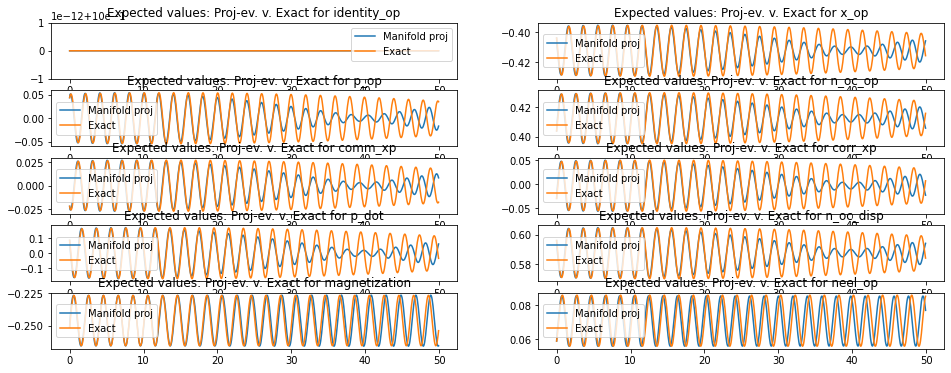

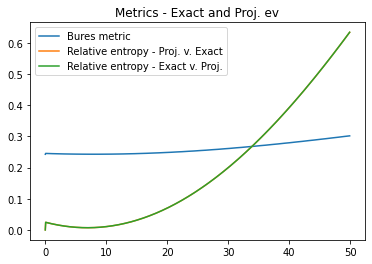

In [7]:
observables = list(cl_ops.values())

depth_and_seed_ops = [(16, cl_ops["identity_op"]),
                      (16, cl_ops["x_op"]),
                      (16, cl_ops["p_op"]),
                      (16, cl_ops["n_oc_op"]),
                      (16, cl_ops["n_oc_disp"]),
                      (1,H_H),
                      (10, K_ref),
                      (1, cl_ops["comm_xp"]),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (1, cl_ops["x_op"]),
                     ]
#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    cl_ops_list = cl_ops, temp = temp, ts = ts,
    observables = observables, visualize_H_evs = False, 
    visualization_nonherm = False, 
    visualize_expt_vals = True
)

In [8]:
rho0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.311+0.j    0.   +0.j    0.   +0.j    0.098+0.372j]
 [0.   +0.j    0.093+0.j    0.04 +0.026j 0.   +0.j   ]
 [0.   +0.j    0.04 -0.026j 0.034+0.j    0.   +0.j   ]
 [0.098-0.372j 0.   +0.j    0.   +0.j    0.562+0.j   ]]

In [ ]:
initial_d_list = [0, 10, 5, 5, 10, 5, 3, 10]
seed_ops_list = observables = list(cl_ops.values())
#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

In [ ]:
initial_d_list = [0, 10, 3, 4, 5, 2, 1, 6]
seed_ops_list = observables = list(cl_ops.values())
#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

In [ ]:
initial_d_list = [0, 5, 5, 50]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

In [ ]:
initial_d_list = [0, 50, 5, 5]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H,  
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

In [ ]:
initial_d_list = [0, 30, 30, 15]
observables = [cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["magnetization"]]
seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_exact_states, res_proj_ev = d_depth_proj_ev(initial_d_list = initial_d_list,
                              seed_ops_list = seed_ops_list, size = N,
                              Hamiltonian = H_H, basis = basis, 
                              cl_ops_list = cl_ops, temp = temp, ts = ts,
                              observables = observables, visualize_H_evs = False, 
                              visualization_nonherm = False, visualize_expt_vals = True)

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations